<a href="https://colab.research.google.com/github/iam-vibhav/SkimLit/blob/main/SkimLitRemake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exploring the data

In [1]:
# Loading the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Files in pubmed 20k rct
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [4]:
import os
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
def get_lines(filename):
  with open(filename, "r") as f:
    lines = f.readlines()
  return lines

In [6]:
train_lines = get_lines(filenames[0])
test_lines = get_lines(filenames[1])
valid_lines = get_lines(filenames[2])

In [7]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_lines_with_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
        abstract_id = line
        abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples


In [9]:
train_samples = preprocess_lines_with_numbers(data_dir + "/" + "train.txt")
val_samples = preprocess_lines_with_numbers(data_dir + "/" + "dev.txt")
test_samples = preprocess_lines_with_numbers(data_dir + "/" + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

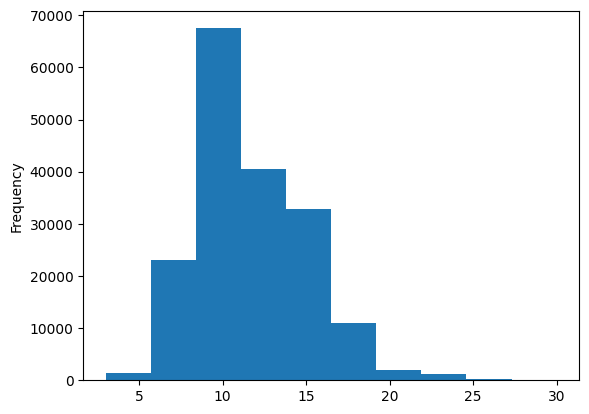

In [13]:
train_df.total_lines.plot(kind="hist")

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

### Numeric Labels

In [15]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1)).toarray()
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)).toarray()
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1)).toarray()

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encoded labels

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
num_classes  = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments

- Naive bayes with TF-IDF encoder(baseline)
- Conv1D with token embeddings
- TensorFlow Hub Pretrained Feature Extractor
- Conv1D with character embeddings
- Pretrained token embeddings + Character embeddings
- Pretrained token embeddings + Character embeddings + Positional Embeddings

### Naive bayes with TF-IDF encoder(baseline)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 =  Pipeline( [
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_true=val_labels_encoded, y_pred=baseline_preds))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



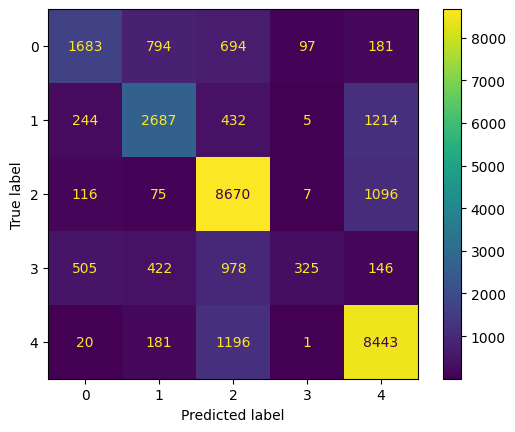

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=val_labels_encoded, y_pred=baseline_preds)
plt.show()


### Preparing the data for deep sequence models

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
sent_lens[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

In [25]:
avg_sent_len = np.mean(sent_lens)
max_sent_len = np.max(sent_lens)
avg_sent_len, max_sent_len

(np.float64(26.338269273494777), np.int64(296))

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

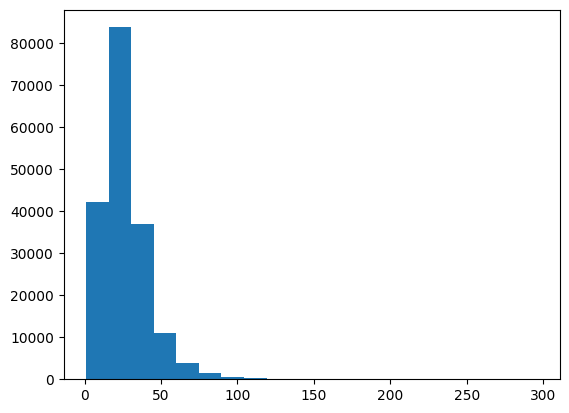

In [26]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [27]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

#### Text Vectorization layer

In [28]:
max_tokens = 68000

In [29]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_mode="int",
                                    output_sequence_length=output_seq_len)

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
print(f"Text : {train_sentences[0]}")
print(f"Vectorized : {text_vectorizer(train_sentences[0])}")

Text : to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .
Vectorized : [   6  331    2   79    4   53    4  161 1127  217 2535    5  557   65
 1584    3  670 5559  636    5    2  654 1137    3  180    2   70  495
   36  781   15   53    5  350  266    7  362    6  289  517 1430 1743
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [32]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Top 5 most common words: {rct_20k_text_vocab[:5]}")

Number of words in vocab: 64841
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]


In [33]:
text_vectorizer.get_config

<bound method TextVectorization.get_config of <TextVectorization name=text_vectorization, built=True>>

#### Text Embedding

In [34]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [35]:
print(f"Text : {train_sentences[0]}")
print(f"Vectorized : {text_vectorizer(train_sentences[0])}")
print(f"Embedded : {token_embed(text_vectorizer(train_sentences[0]))}")

Text : to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .
Vectorized : [   6  331    2   79    4   53    4  161 1127  217 2535    5  557   65
 1584    3  670 5559  636    5    2  654 1137    3  180    2   70  495
   36  781   15   53    5  350  266    7  362    6  289  517 1430 1743
    0    0    0    0    0    0    0    0    0    0    0    0    0]
Embedded : [[-0.02815721 -0.01576317 -0.0132897  ...  0.0072871   0.00559294
   0.03823343]
 [ 0.01633896  0.02715668  0.00482557 ...  0.03357974  0.02819115
   0.01171257]
 [-0.01791341  0.04638873  0.02481223 ...  0.0033496   0.04667194
  -0.01381656]
 ...
 [ 0.04872062  0.02909657  0.00716173 ...  0.02567374 -0.01914718
  -0.02842885]
 [ 0.04872062  0.02909657  0.00716173 ...  0.02567374 -0.01914718
  -0.0284288

### Creating datasets(Tfds)

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Batching the data
train_dataset = train_dataset.batch(32)
valid_dataset = valid_dataset.batch(32)
test_dataset = test_dataset.batch(32)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Conv1D with token embeddings

In [38]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")


model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [39]:
model_1.summary()

Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))
                              )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5228 - loss: 1.1567 - val_accuracy: 0.7374 - val_loss: 0.6900
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.7451 - loss: 0.6854 - val_accuracy: 0.7709 - val_loss: 0.6398
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.7703 - loss: 0.6258 - val_accuracy: 0.7842 - val_loss: 0.5981


In [41]:
# Evaluation
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7858 - loss: 0.5971


[0.5999216437339783, 0.786541759967804]

In [42]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


(array([[4.0535274e-01, 1.8000123e-01, 1.0031560e-01, 2.7927950e-01,
         3.5050910e-02],
        [4.2337066e-01, 3.1538418e-01, 8.6467033e-03, 2.4541406e-01,
         7.1843355e-03],
        [1.9610074e-01, 9.3850587e-03, 2.1382028e-03, 7.9233235e-01,
         4.3592139e-05],
        ...,
        [5.6664867e-06, 9.2838873e-04, 7.8336056e-04, 2.5388833e-06,
         9.9828005e-01],
        [4.5666300e-02, 4.2174834e-01, 9.9216618e-02, 4.4360910e-02,
         3.8900793e-01],
        [1.8645984e-01, 6.1271012e-01, 6.4420320e-02, 4.4947688e-02,
         9.1462016e-02]], dtype=float32),
 (30212, 5))

In [43]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
print(classification_report(y_true=val_labels_encoded, y_pred=model_1_preds))

              precision    recall  f1-score   support

           0       0.62      0.54      0.57      3449
           1       0.69      0.71      0.70      4582
           2       0.86      0.88      0.87      9964
           3       0.61      0.57      0.59      2376
           4       0.85      0.87      0.86      9841

    accuracy                           0.79     30212
   macro avg       0.72      0.71      0.72     30212
weighted avg       0.78      0.79      0.78     30212



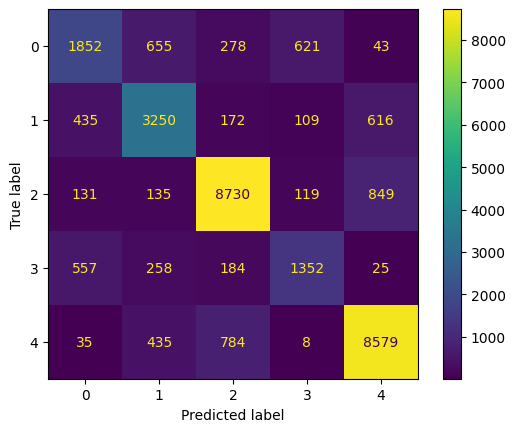

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=val_labels_encoded, y_pred=model_1_preds)
plt.show()


### TensorFlow Hub Pretrained Feature Extractor

In [46]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                 trainable=False,
                                                 name="universal_sentence_encoder")

In [47]:
print(f"Text : {train_sentences[0]}")
print(f"Embedded : {tf_hub_embedding_layer([train_sentences[0]])}")

Text : to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .
Embedded : [[-4.90380190e-02  5.24623469e-02  3.95998769e-02 -6.31776527e-02
  -7.30676949e-02  6.28731549e-02  3.52799147e-02 -6.18203990e-02
   5.71083315e-02  4.63245437e-02  7.16570467e-02  2.51986482e-03
  -9.52069461e-03  6.51004585e-03  3.80008966e-02  3.74654084e-02
  -7.96469301e-02  6.41185641e-02  3.50537933e-02 -3.88272814e-02
   1.50759676e-02 -1.20223127e-02  1.47859147e-02 -2.70260908e-02
   1.51410745e-02  5.35054095e-02 -6.14335295e-03 -3.47358286e-02
  -7.48624653e-02  2.86217057e-03 -5.25581799e-02  7.89910331e-02
   7.17563331e-02  1.59457568e-02 -6.31276295e-02  1.22191636e-02
  -1.35266203e-02 -3.82611342e-02 -1.69011988e-02 -6.66884407e-02
  -4.18503843e-02  7.29317218e-02 -1.603

In [48]:
class USEEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(USEEmbeddingLayer, self).__init__(**kwargs)
        self.use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable=False,
                                  name="universal_sentence_encoder")

    def call(self, inputs):
        return self.use(inputs)

inputs = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")
x = USEEmbeddingLayer()(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_2_USE_feature_extractor")


model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()


Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding_layer             │ (None, 512)            │             0 │
│ (USEEmbeddingLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:

history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))
                              )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5680 - loss: 1.0939 - val_accuracy: 0.6882 - val_loss: 0.8001
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7043 - loss: 0.7715 - val_accuracy: 0.7061 - val_loss: 0.7578
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7130 - loss: 0.7554 - val_accuracy: 0.7094 - val_loss: 0.7408


In [50]:
# Evaluation
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7135 - loss: 0.7402


[0.7414167523384094, 0.7136237025260925]

In [51]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


(array([[4.2901018e-01, 3.8158917e-01, 1.9976080e-03, 1.8003465e-01,
         7.3683476e-03],
        [3.4395781e-01, 5.0252664e-01, 3.2920691e-03, 1.4720261e-01,
         3.0208628e-03],
        [2.4530944e-01, 1.5443899e-01, 1.9195966e-02, 5.4278904e-01,
         3.8266432e-02],
        ...,
        [1.7202889e-03, 6.4925714e-03, 6.3386083e-02, 8.8176149e-04,
         9.2751932e-01],
        [3.9873361e-03, 4.8217252e-02, 1.7387499e-01, 1.5585087e-03,
         7.7236181e-01],
        [1.9842251e-01, 2.3819096e-01, 5.0770926e-01, 7.0409840e-03,
         4.8636355e-02]], dtype=float32),
 (30212, 5))

In [52]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [53]:
print(classification_report(y_true=val_labels_encoded, y_pred=model_2_preds))

              precision    recall  f1-score   support

           0       0.61      0.41      0.49      3449
           1       0.57      0.67      0.61      4582
           2       0.79      0.79      0.79      9964
           3       0.53      0.54      0.54      2376
           4       0.79      0.81      0.80      9841

    accuracy                           0.71     30212
   macro avg       0.66      0.64      0.64     30212
weighted avg       0.71      0.71      0.71     30212



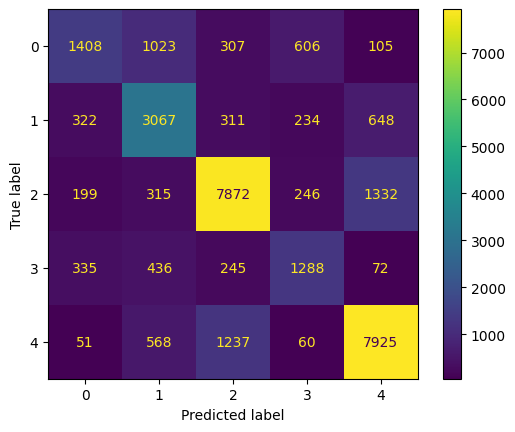

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=val_labels_encoded, y_pred=model_2_preds)
plt.show()


### Conv1D with character embeddings


#### Character Level Tokenizer layer

In [55]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [56]:
def split_chars(text):
  return " ".join(list(text))

split_chars(train_sentences[10])

't h e   o u t c o m e   m e a s u r e s   i n   r h e u m a t o l o g y   c l i n i c a l   t r i a l s - o s t e o a r t h r i t i s   r e s e a r c h   s o c i e t y   i n t e r n a t i o n a l   r e s p o n d e r   r a t e   w a s   @   %   i n   t h e   i n t e r v e n t i o n   g r o u p   a n d   @   %   i n   t h e   p l a c e b o   g r o u p   (   p   <   @   )   .'

In [57]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [58]:
chars_lens = [len(char) for char in train_chars]
avg_chars_len = np.mean(chars_lens)
max_chars_len = np.max(chars_lens)
avg_chars_len, max_chars_len

(np.float64(297.7325149966674), np.int64(2771))

(array([2.0600e+03, 1.0281e+04, 2.1922e+04, 2.8139e+04, 3.0289e+04,
        2.6219e+04, 1.9853e+04, 1.4492e+04, 9.6420e+03, 6.1370e+03,
        4.0170e+03, 2.5600e+03, 1.5340e+03, 9.3500e+02, 6.4300e+02,
        4.4600e+02, 2.5600e+02, 1.8800e+02, 1.1900e+02, 8.0000e+01,
        5.8000e+01, 4.7000e+01, 2.6000e+01, 2.4000e+01, 1.2000e+01,
        1.2000e+01, 1.0000e+01, 9.0000e+00, 7.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 5.6400e+01, 1.1180e+02, 1.6720e+02, 2.2260e+02,
        2.7800e+02, 3.3340e+02, 3.8880e+02, 4.4420e+02, 4.9960e+02,
        5.5500e+02, 6.1040e+02, 6.6580e+02, 7.2120e+02, 7.7660e+02,
        8.3200e+02, 8.8740e+02, 9.4280e+02, 9.9820e+02, 1.0536e+03,
        1.1090e+03, 1.1644e+03, 1.2198e+03, 1.

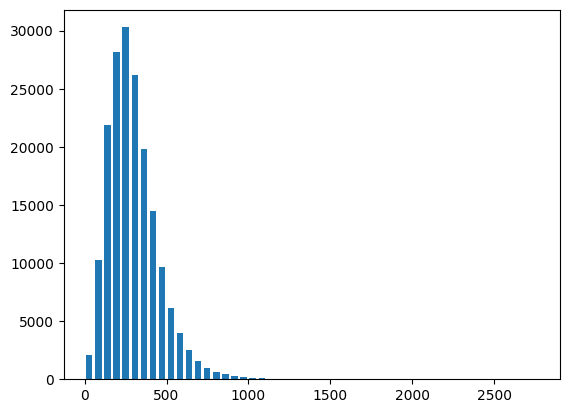

In [59]:
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=50, rwidth=0.7)


In [60]:
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

579

In [61]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
# Creating a character vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [63]:
char_vectorizer.adapt(train_chars)

In [64]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab[:10]

['',
 '[UNK]',
 np.str_('e'),
 np.str_('t'),
 np.str_('i'),
 np.str_('a'),
 np.str_('n'),
 np.str_('o'),
 np.str_('r'),
 np.str_('s')]

In [65]:
import random
random_train_chars = random.choice(train_chars)
print(f"Charified train  : {random_train_chars}")
print(f"Length of random_train_chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer(random_train_chars)
print(f"Vectorized : {vectorized_chars}")
print(f"Length of vectorized : {len(vectorized_chars)}")

Charified train  : t h e r e   w a s   n o   d i f f e r e n c e   i n   t h e   c o m p l e t e n e s s   o f   h i s t o r y   o b t a i n e d   b e t w e e n   t h e   e x p e r i m e n t a l   g r o u p   a n d   t h e   c o n t r o l   g r o u p   (   @   %   ,   s d   =   @   v s   @   %   ,   s d   =   @   ;   p   =   @   )   .
Length of random_train_chars : 122
Vectorized : [ 3 13  2  8  2 20  5  9  6  7 10  4 17 17  2  8  2  6 11  2  4  6  3 13
  2 11  7 15 14 12  2  3  2  6  2  9  9  7 17 13  4  9  3  7  8 19  7 22
  3  5  4  6  2 10 22  2  3 20  2  2  6  3 13  2  2 24 14  2  8  4 15  2
  6  3  5 12 18  8  7 16 14  5  6 10  3 13  2 11  7  6  3  8  7 12 18  8
  7 16 14  9 10 21  9  9 10 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

#### Character Level Embedding Layer

In [66]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")


In [67]:
print(f"Charified Text : {random_train_chars}")
print(f"Vectorized : {vectorized_chars}")
print(f"Embedded : {char_embed(vectorized_chars)}")
print(f"Shape : {char_embed(vectorized_chars).shape}")

Charified Text : t h e r e   w a s   n o   d i f f e r e n c e   i n   t h e   c o m p l e t e n e s s   o f   h i s t o r y   o b t a i n e d   b e t w e e n   t h e   e x p e r i m e n t a l   g r o u p   a n d   t h e   c o n t r o l   g r o u p   (   @   %   ,   s d   =   @   v s   @   %   ,   s d   =   @   ;   p   =   @   )   .
Vectorized : [ 3 13  2  8  2 20  5  9  6  7 10  4 17 17  2  8  2  6 11  2  4  6  3 13
  2 11  7 15 14 12  2  3  2  6  2  9  9  7 17 13  4  9  3  7  8 19  7 22
  3  5  4  6  2 10 22  2  3 20  2  2  6  3 13  2  2 24 14  2  8  4 15  2
  6  3  5 12 18  8  7 16 14  5  6 10  3 13  2 11  7  6  3  8  7 12 18  8
  7 16 14  9 10 21  9  9 10 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

#### Conv1D with character embeddings

In [68]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import TextVectorization

inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [69]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 579)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 579, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 579, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
 # Creating tfds from char data

train_char_dataset = tf.data.Dataset.from_tensor_slices( (train_chars, train_labels_one_hot)).batch(32)
val_char_dataset = tf.data.Dataset.from_tensor_slices( (val_chars, val_labels_one_hot)).batch(32)
test_char_dataset = tf.data.Dataset.from_tensor_slices( (test_chars, test_labels_one_hot)).batch(32)

train_char_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset))
                              )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4215 - loss: 1.3851 - val_accuracy: 0.5971 - val_loss: 1.0196
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.5954 - loss: 1.0206 - val_accuracy: 0.6356 - val_loss: 0.9225
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.6392 - loss: 0.9249 - val_accuracy: 0.6636 - val_loss: 0.8542


In [72]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs, model_3_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


(array([[0.24694082, 0.343136  , 0.06240211, 0.31061676, 0.03690429],
        [0.23092201, 0.5079881 , 0.02080019, 0.22997002, 0.01031968],
        [0.16608356, 0.14753917, 0.18823527, 0.4669129 , 0.03122907],
        ...,
        [0.02493381, 0.05690382, 0.1300528 , 0.04394624, 0.74416333],
        [0.02685341, 0.09454821, 0.36116928, 0.05124424, 0.46618482],
        [0.47090846, 0.2756039 , 0.15583503, 0.07781415, 0.01983852]],
       dtype=float32),
 (30212, 5))

In [73]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [74]:
from sklearn.metrics import classification_report

print(classification_report(y_true=val_labels_encoded,
                            y_pred = model_3_preds))

              precision    recall  f1-score   support

           0       0.47      0.33      0.39      3449
           1       0.52      0.45      0.48      4582
           2       0.71      0.84      0.77      9964
           3       0.41      0.47      0.44      2376
           4       0.78      0.73      0.76      9841

    accuracy                           0.66     30212
   macro avg       0.58      0.57      0.57     30212
weighted avg       0.65      0.66      0.65     30212



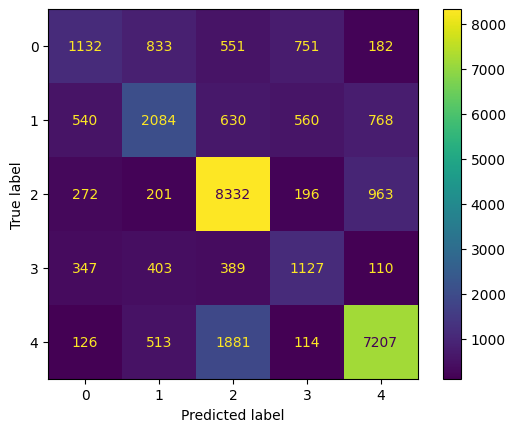

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=val_labels_encoded, y_pred=model_3_preds)
plt.show()

### Pretrained token embeddings + Character embeddings

In [76]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Load Universal Sentence Encoder
use_model = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           name="universal_sentence_encoder")

# Token level model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")

# Lambda wrapper
token_embeddings = layers.Lambda(
    lambda x: use_model(x),
    output_shape=(512,),
    name="use_lambda"
)(token_inputs)

token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs, name="token_model")

# Character level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm, name="char_model")

# Combine token + char features
token_char_concat = layers.Concatenate(name="token_char_hybrid")([
    token_model.output,
    char_model.output
])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(64, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)

# Define output
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Final hybrid model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_char_hybrid")


In [77]:
model_4.summary()

Model: "model_4_token_char_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 579)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_lambda (Lambda) │ (None, 512)       │          0 │ token_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 579, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 579)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ use_lambda[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[1][0], │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 176)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     11,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │        325 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

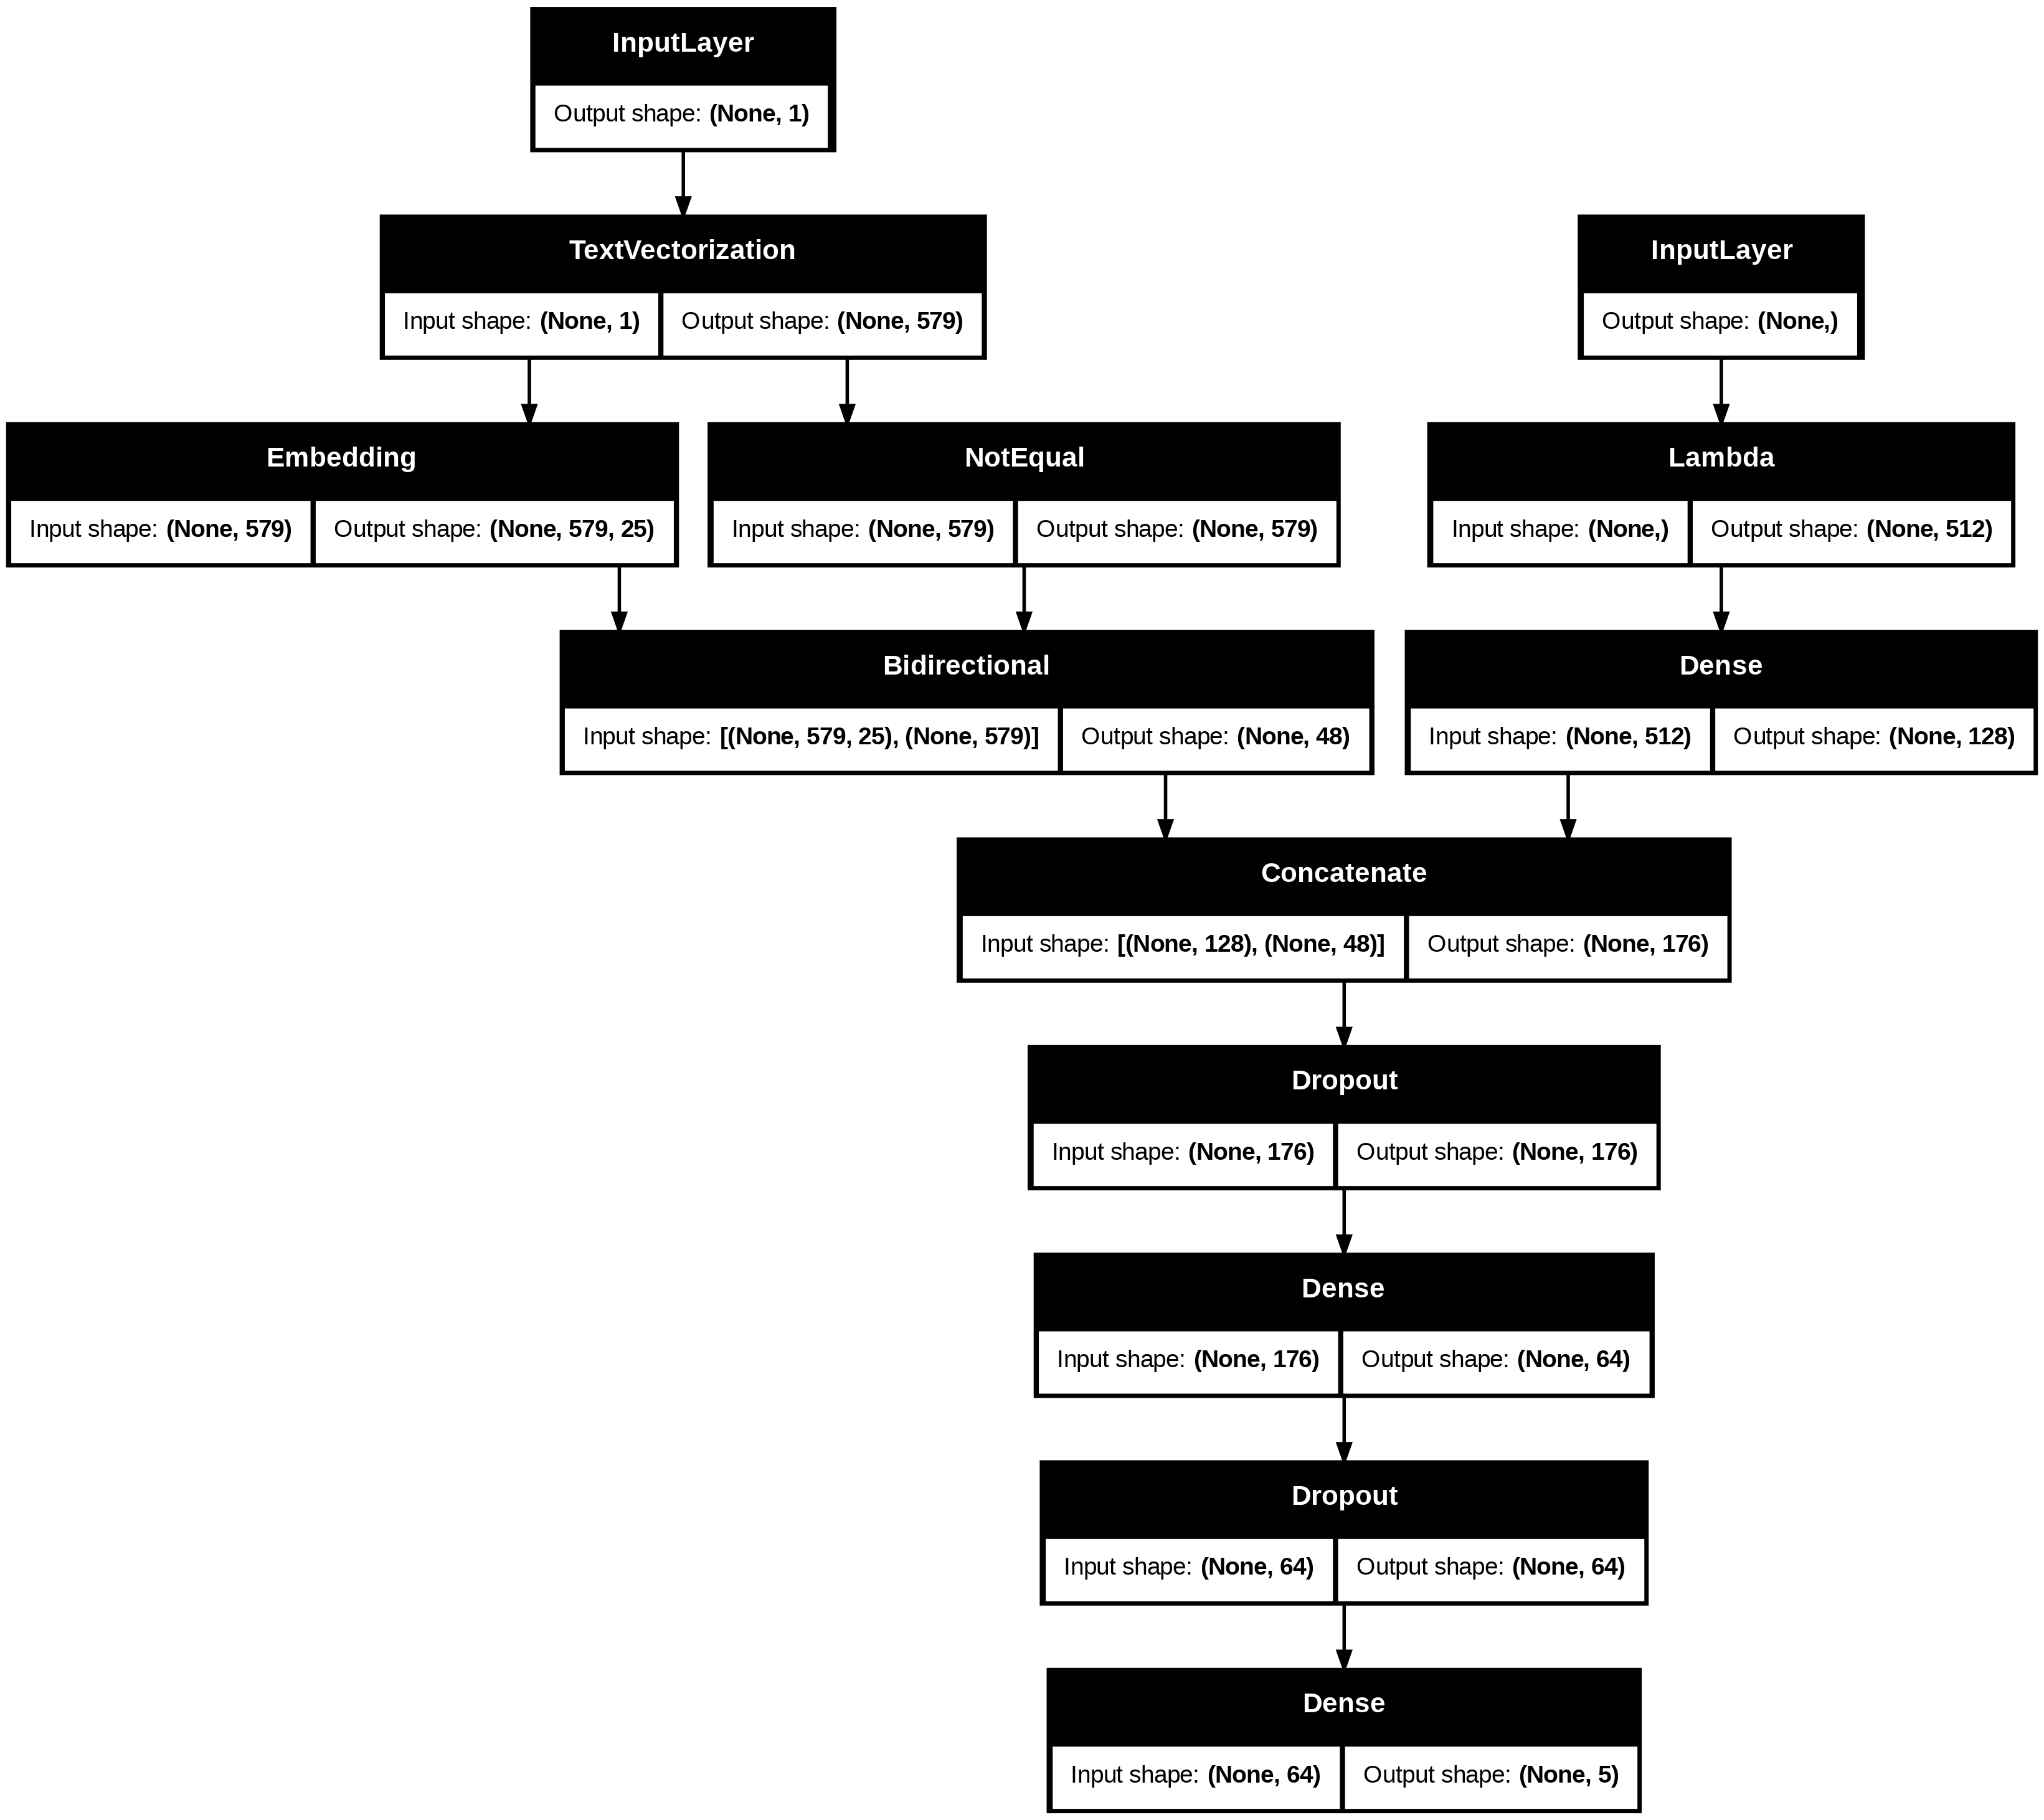

In [78]:
from keras.utils import plot_model

plot_model(model_4,
           show_shapes=True)

In [79]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [80]:
# Combining token and character data

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32)



val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32)



test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32)

In [81]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 187s 322ms/step - accuracy: 0.5096 - loss: 1.1891 - val_accuracy: 0.6928 - val_loss: 0.8099
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 184s 327ms/step - accuracy: 0.6774 - loss: 0.8450 - val_accuracy: 0.7211 - val_loss: 0.7342
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 201s 358ms/step - accuracy: 0.6919 - loss: 0.8048 - val_accuracy: 0.7327 - val_loss: 0.7055


In [82]:
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.7289 - loss: 0.7068


[0.7078673243522644, 0.7286508679389954]

In [83]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step


array([[3.9365655e-01, 4.2324531e-01, 8.9996550e-03, 1.6464923e-01,
        9.4492435e-03],
       [3.7574914e-01, 4.3372580e-01, 7.4642091e-03, 1.8016002e-01,
        2.9007855e-03],
       [3.0756128e-01, 1.4725539e-01, 5.6580249e-02, 4.5205939e-01,
        3.6543775e-02],
       ...,
       [5.3543900e-04, 6.6729118e-03, 4.6446141e-02, 2.1765847e-04,
        9.4612783e-01],
       [8.8497028e-03, 5.7292894e-02, 2.6610997e-01, 4.7209263e-03,
        6.6302651e-01],
       [3.7792134e-01, 2.3035382e-01, 3.1429297e-01, 2.4184439e-02,
        5.3247485e-02]], dtype=float32)

In [84]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_true=val_labels_encoded,
                            y_pred = model_4_preds))


              precision    recall  f1-score   support

           0       0.57      0.43      0.49      3449
           1       0.58      0.67      0.62      4582
           2       0.80      0.82      0.81      9964
           3       0.59      0.59      0.59      2376
           4       0.81      0.81      0.81      9841

    accuracy                           0.73     30212
   macro avg       0.67      0.66      0.66     30212
weighted avg       0.73      0.73      0.73     30212



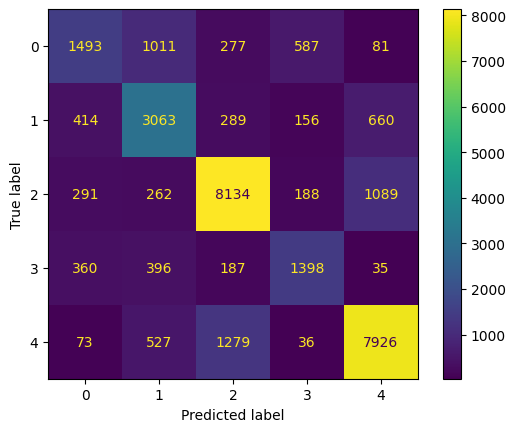

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=val_labels_encoded, y_pred=model_4_preds)
plt.show()

### Pretrained token embeddings + Character embeddings + Positional Embeddings

In [87]:
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

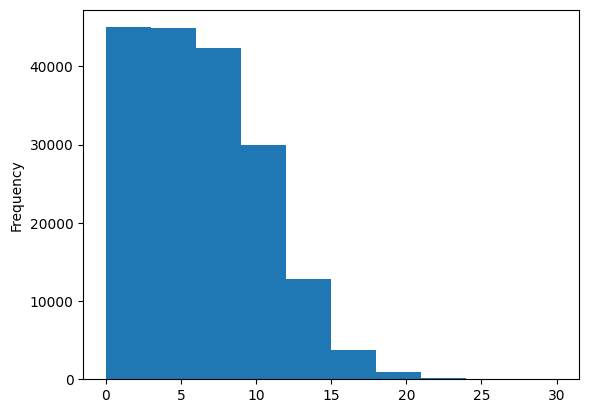

In [88]:
train_df["line_number"].plot.hist()

In [89]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [90]:
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

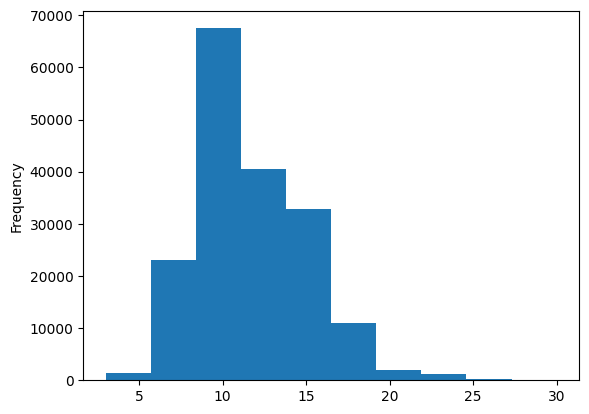

In [91]:
train_df["total_lines"].plot.hist()

In [92]:
np.percentile(train_df.total_lines, 95)

np.float64(18.0)

In [93]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [94]:
# Building the tribrid embedding model

use_model = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=True,
                           name="universal_sentence_encoder")

token_inputs = layers.Input(shape=(), dtype="string", name="token_inputs")
token_embeddings = layers.Lambda(lambda x: use_model(x),
                                 output_shape=(512,),
                                 name="use_lambda")(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype="float32", name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype="float32", name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                            outputs=y)

combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)


tribrid_embeddings = layers.Concatenate(name="char_token_posotional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)


model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [95]:
model_5.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 579)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_lambda (Lambda) │ (None, 512)       │          0 │ token_inputs[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 579, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 579)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     65,664 │ use_lambda[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48)        │      9,600 │ char_embed[2][0], │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_posotio… │ (None, 320)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ char_token_posot… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

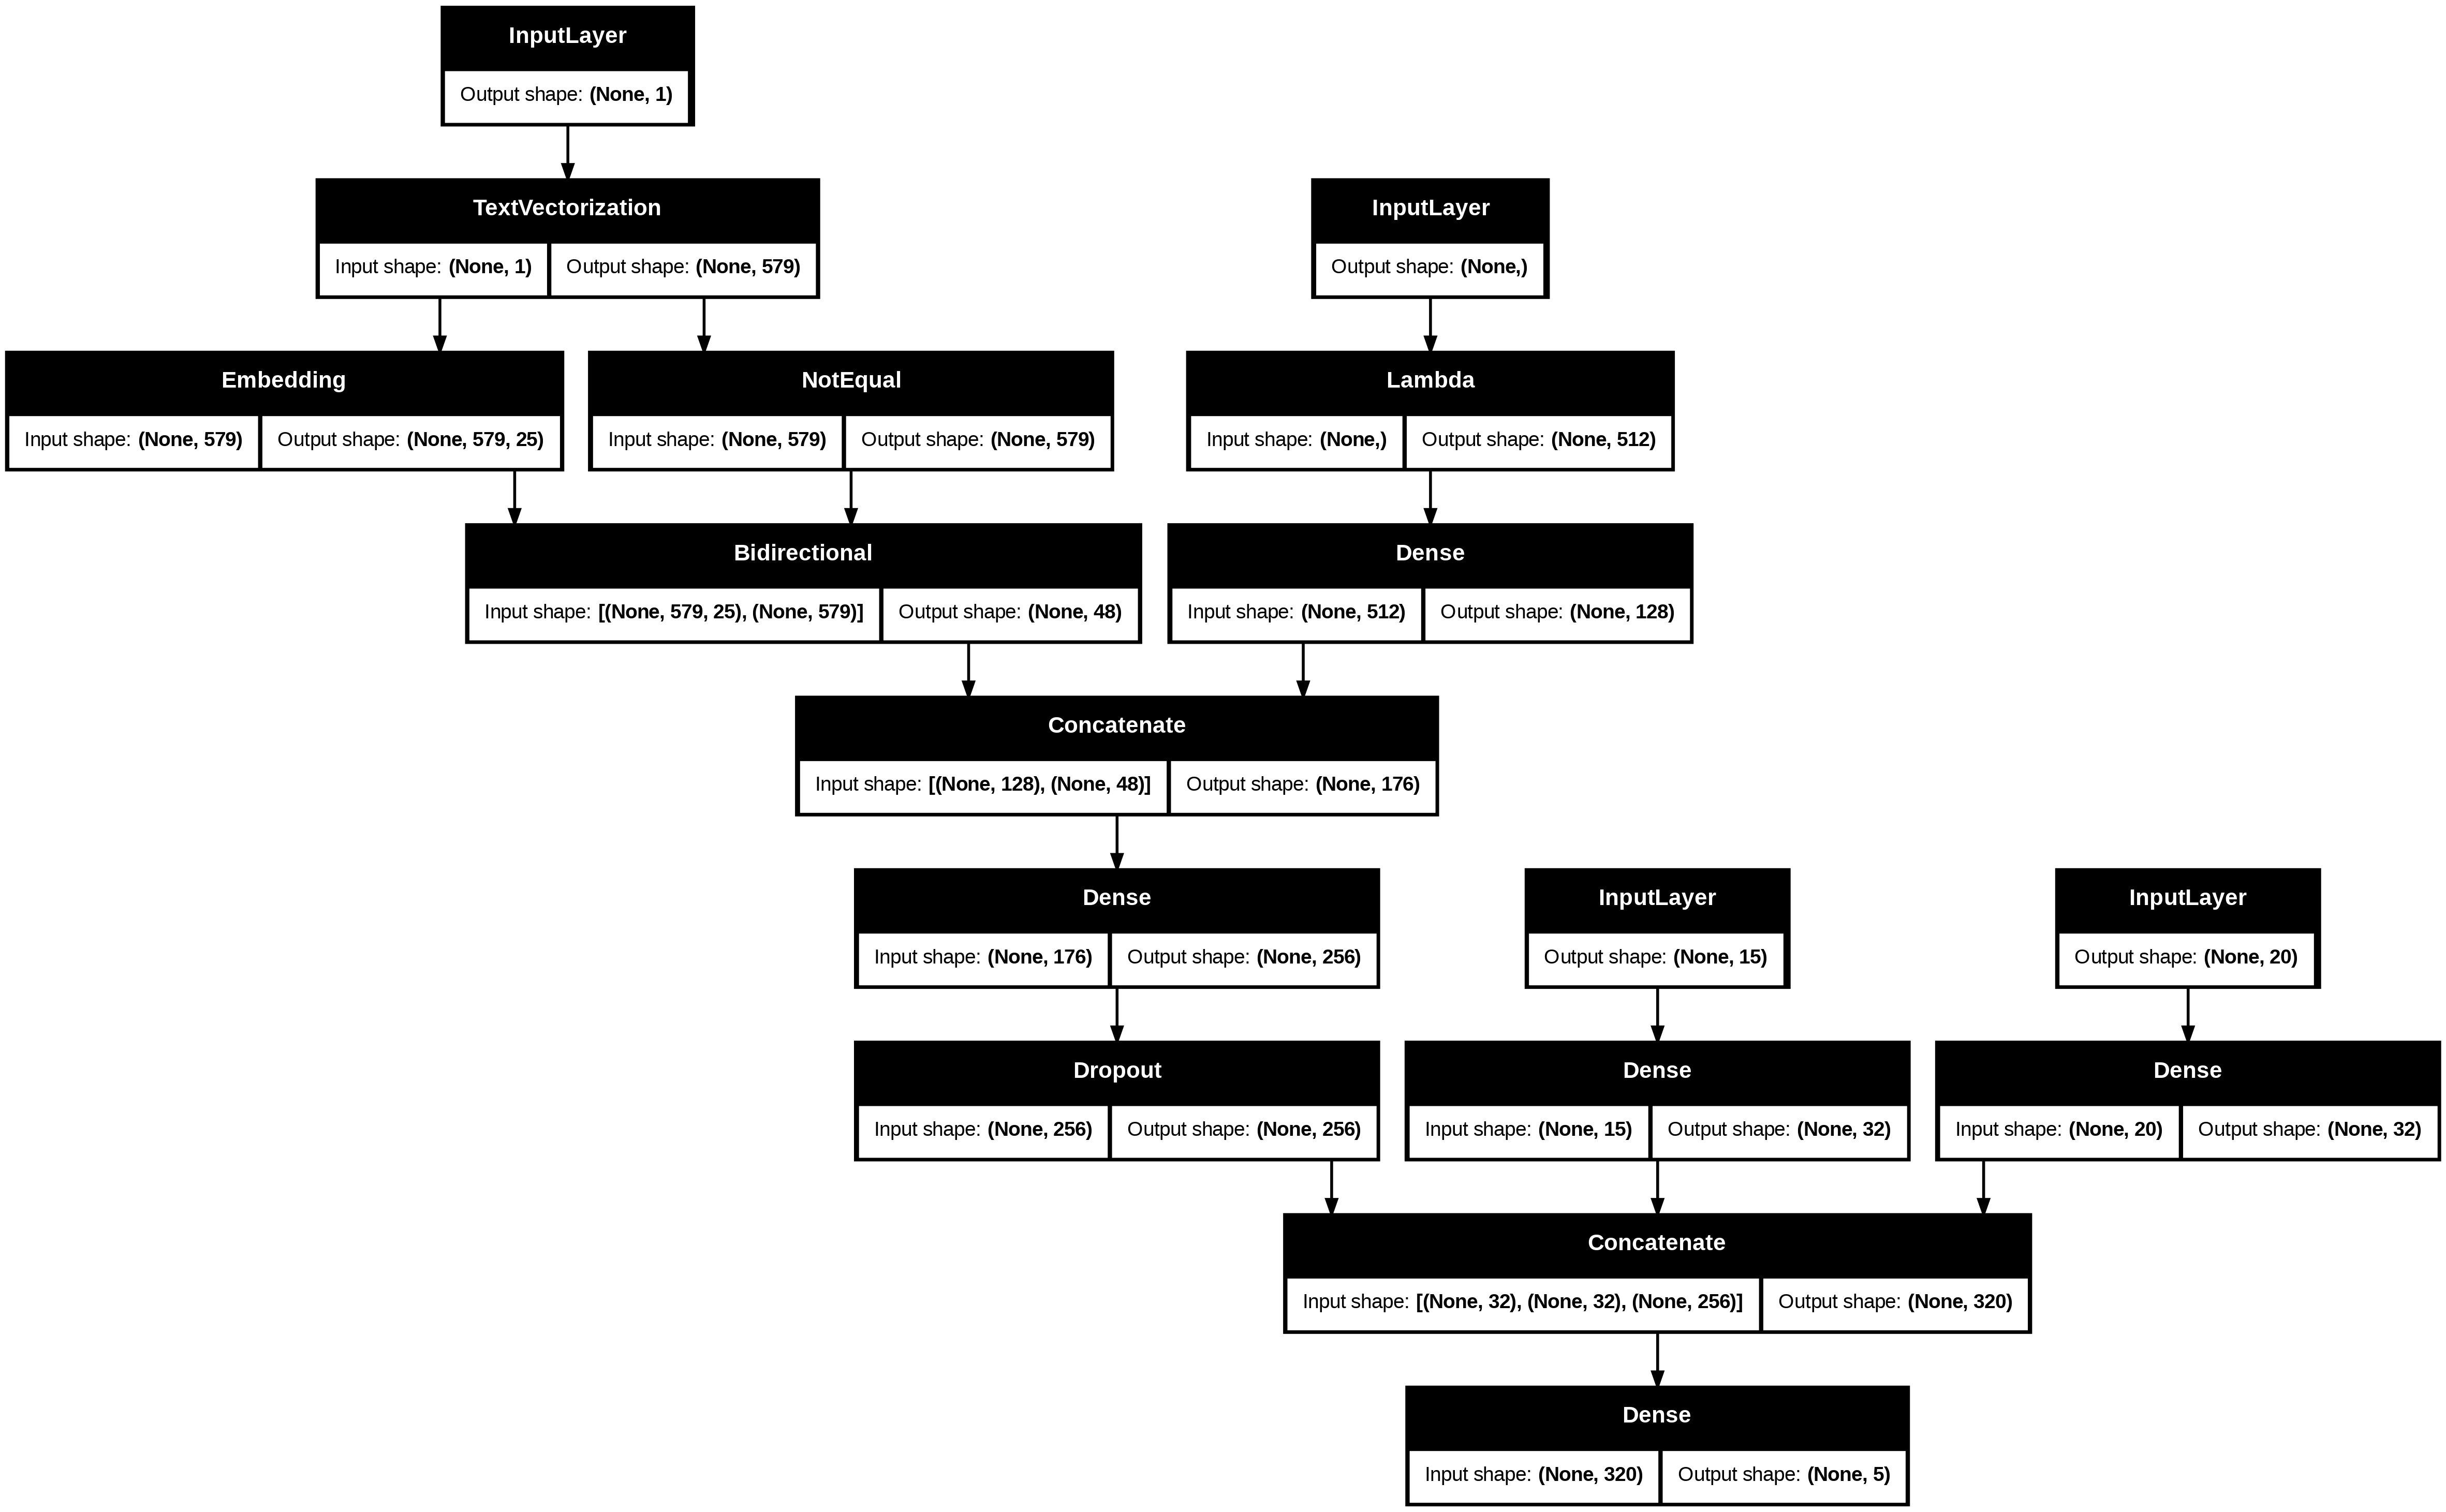

In [96]:
from tensorflow.keras.utils import plot_model

plot_model(model_5, show_shapes=True)

In [97]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [98]:
# Creating tribrid datasets

# Training dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                 train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32)


# Validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                               val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32)


# Test dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,
                                                test_char_token_pos_labels))

test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32)


#### Cleaning up some RAM for model_5 to run

In [99]:
# Storing the results of previous models for reference
from sklearn.metrics import f1_score


model_accuracies = {
    "Naive Bayes + TF-IDF": model_0.score(val_sentences, val_labels_encoded),
    "Conv1D Token Embeddings": history_model_1.history['val_accuracy'][-1],
    "USE Feature Extractor": history_model_2.history['val_accuracy'][-1],
    "Conv1D Char Embeddings": model_3_history.history['val_accuracy'][-1],
    "Token + Char Embeddings": history_model_4.history['val_accuracy'][-1],
    "Token + Char + Positional": 0,
}

model_f1_scores = {
    "Naive Bayes + TF-IDF": f1_score(val_labels_encoded, baseline_preds, average="weighted"),
    "Conv1D Token Embeddings": f1_score(val_labels_encoded, model_1_preds, average="weighted"),
    "USE Feature Extractor": f1_score(val_labels_encoded, model_2_preds, average="weighted"),
    "Conv1D Char Embeddings": f1_score(val_labels_encoded, model_3_preds, average="weighted"),
    "Token + Char Embeddings": f1_score(val_labels_encoded, model_4_preds, average="weighted"),
    "Token + Char + Positional": 0,
}

In [100]:
import gc
from tensorflow.keras import backend as K



# Clear unused models (keep only model_5)
try: del model_0
except: pass
try: del model_1
except: pass
try: del model_2
except: pass
try: del model_3
except: pass
try: del model_4
except: pass

# Clear model histories
for hist in ["history_model_0", "history_model_1", "history_model_2",
             "model_3_history", "history_model_4"]:
    try:
        del globals()[hist]
    except:
        pass

# Clear datasets not needed by model_5
for ds in ["train_dataset", "valid_dataset", "test_dataset",
           "train_char_dataset", "val_char_dataset", "test_char_dataset",
           "train_char_token_dataset", "val_char_token_dataset", "test_char_token_dataset"]:
    try:
        del globals()[ds]
    except:
        pass

# Clear TensorFlow backend session
K.clear_session()

# Run garbage collector
gc.collect()


33421

#### Now running model_5

In [113]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_accuracy",
                               patience=3,
                               restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

history_model_5 = model_5.fit(
    train_char_token_pos_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
    epochs=20,  # try more
    validation_data=val_char_token_pos_dataset,
    validation_steps=int(0.1*len(val_char_token_pos_dataset)),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 192s 342ms/step - accuracy: 0.8378 - loss: 0.7325 - val_accuracy: 0.8484 - val_loss: 0.7079 - learning_rate: 0.0010
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 201s 358ms/step - accuracy: 0.8538 - loss: 0.6989 - val_accuracy: 0.8531 - val_loss: 0.6987 - learning_rate: 0.0010
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 194s 345ms/step - accuracy: 0.8516 - loss: 0.6982 - val_accuracy: 0.8447 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8553 - loss: 0.6919
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
562/562 ━━━━━━━━━━━━━━━━━━━━ 202s 359ms/step - accuracy: 0.8553 - loss: 0.6919 - val_accuracy: 0.8447 - val_loss: 0.6989 - learning_rate: 0.0010
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 202s 359ms/step - accuracy: 0.8583 - loss: 0.6875 - val_accuracy: 0.8514 - val_loss: 0.6907 - learning_rate: 5.0000e-04


In [114]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 58s 61ms/step


In [115]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [116]:
from sklearn.metrics import classification_report

print(classification_report(y_true=val_labels_encoded,
                            y_pred=model_5_preds))


              precision    recall  f1-score   support

           0       0.73      0.74      0.74      3449
           1       0.86      0.87      0.87      4582
           2       0.87      0.92      0.90      9964
           3       0.69      0.62      0.65      2376
           4       0.90      0.86      0.88      9841

    accuracy                           0.85     30212
   macro avg       0.81      0.80      0.81     30212
weighted avg       0.85      0.85      0.85     30212



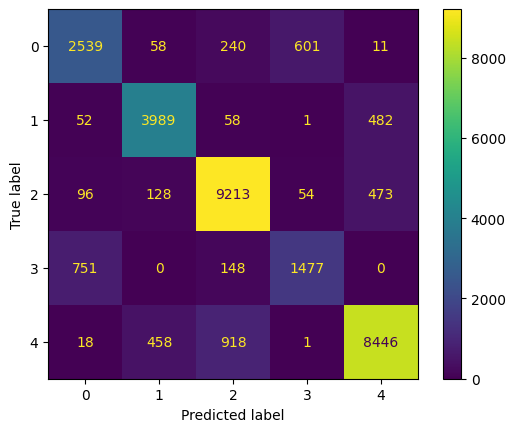

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=val_labels_encoded, y_pred=model_5_preds)
plt.show()

### Comparing the performance of all the models

In [118]:
from sklearn.metrics import f1_score


model_accuracies["Token + Char + Positional"] = history_model_5.history['val_accuracy'][-1]


model_f1_scores["Token + Char + Positional"] = f1_score(val_labels_encoded, model_5_preds, average="weighted")


In [119]:
# Function to plot the results of all the models
import matplotlib.pyplot as plt

def plot_model_metrics(accuracies_dict, metric_name="Metric"):
    plt.figure(figsize=(10,6))
    bars = plt.bar(accuracies_dict.keys(), accuracies_dict.values(), color="skyblue")
    plt.ylabel(metric_name)
    plt.title("Model Comparison on SkimLit Remake")
    plt.xticks(rotation=25, ha="right")


    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f"{height:.3f}", ha="center", va="bottom")

    plt.show()

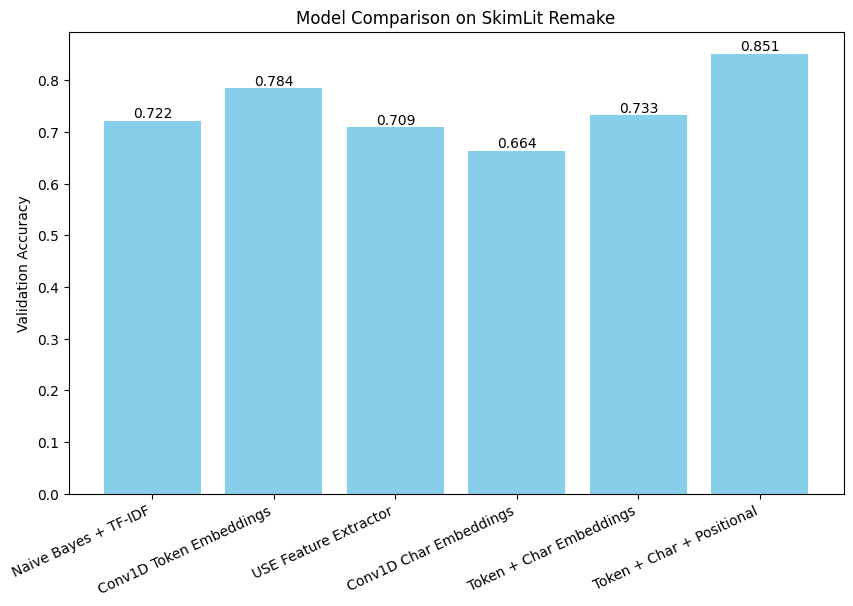

In [120]:
# Ploting the accuracies of all the models
plot_model_metrics(model_accuracies, "Validation Accuracy")

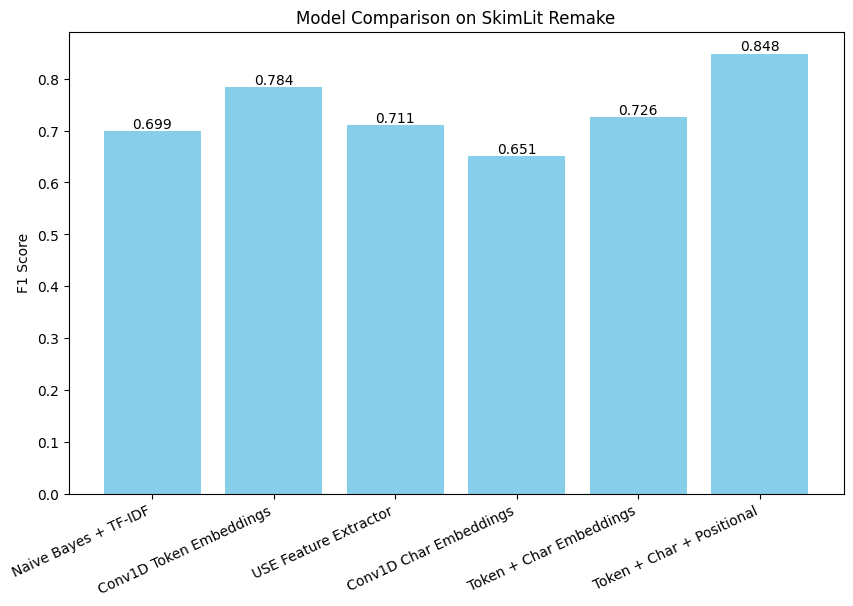

In [121]:
# Plotting F1 scores of all the models
plot_model_metrics(model_f1_scores, "F1 Score")

### Creating a wrapper function to test the function on actual research papers

In [126]:
# Wrapper with optional sentence tokenization
import tensorflow as tf
import numpy as np

# Choose tokenization backend: "spacy" or "nltk"
USE_SPACY = True

if USE_SPACY:
    import spacy
    nlp = spacy.load("en_core_web_sm")
else:
    import nltk
    nltk.download("punkt")
    from nltk.tokenize import sent_tokenize

def preprocess_research_paper(raw_text):
    """
    Converts a raw research paper string into a list of abstract-style lines
    formatted like the training data.
    Uses spaCy or NLTK to split into sentences.
    """
    if USE_SPACY:
        doc = nlp(raw_text)
        lines = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
    else:
        lines = [line.strip() for line in sent_tokenize(raw_text) if line.strip()]

    abstract_samples = []
    for i, line in enumerate(lines):
        line_data = {
            "target": "UNKNOWN",
            "text": line.lower(),
            "line_number": i,
            "total_lines": len(lines) - 1
        }
        abstract_samples.append(line_data)

    return abstract_samples


def create_prediction_dataset(abstract_samples):
    """
    Converts processed abstract samples into the 4 inputs expected by model_5:
    - line numbers one-hot
    - total lines one-hot
    - token sentences
    - character sentences
    """
    sentences = [sample["text"] for sample in abstract_samples]
    line_numbers = [sample["line_number"] for sample in abstract_samples]
    total_lines = [sample["total_lines"] for sample in abstract_samples]

    # Character-level text
    char_sentences = [" ".join(list(s)) for s in sentences]

    # One-hot encode line_number and total_lines
    line_numbers_one_hot = tf.one_hot(line_numbers, depth=15)
    total_lines_one_hot = tf.one_hot(total_lines, depth=20)

    # Create tf.data.Dataset
    char_token_pos_data = tf.data.Dataset.from_tensor_slices((
        line_numbers_one_hot,
        total_lines_one_hot,
        sentences,
        char_sentences
    ))

    dummy_labels = tf.data.Dataset.from_tensor_slices(
        tf.zeros((len(sentences), num_classes))
    )

    dataset = tf.data.Dataset.zip((char_token_pos_data, dummy_labels))
    dataset = dataset.batch(32)
    return dataset, sentences


def predict_research_paper(raw_text):
    """
    Full pipeline: preprocess -> dataset -> model_5 prediction.
    Returns predicted labels for each sentence.
    """
    abstract_samples = preprocess_research_paper(raw_text)
    dataset, sentences = create_prediction_dataset(abstract_samples)

    pred_probs = model_5.predict(dataset)
    preds = tf.argmax(pred_probs, axis=1)

    pred_labels = [class_names[p] for p in preds.numpy()]

    return [{"text": s, "prediction": l} for s, l in zip(sentences, pred_labels)]


In [128]:
raw_text = """
The paper discusses the results of a study which explored advanced learners of English
engagement with their mobile devices to develop learning experiences that meet their
needs and goals as foreign language learners. The data were collected from 20 students
by means of a semi-structured interview. The gathered data were subjected to
qualitative and quantitative analysis. The results of the study demonstrated that, on the
one hand, some subjects manifested heightened awareness relating to the
advantageous role of mobile devices in their learning endeavors, their ability to reach
for suitable tools and retrieve necessary information so as to achieve their goals, meet
their needs and adjust their learning of English to their personal learning styles, and on
the other, a rather intuitive and/or ad hoc use of their mobile devices in the classroom.

"""

results = predict_research_paper(raw_text)
for r in results:
    print(f"{r['prediction']}: {r['text']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
OBJECTIVE: the paper discusses the results of a study which explored advanced learners of english
engagement with their mobile devices to develop learning experiences that meet their
needs and goals as foreign language learners.
METHODS: the data were collected from 20 students
by means of a semi-structured interview.
METHODS: the gathered data were subjected to
qualitative and quantitative analysis.
METHODS: the results of the study demonstrated that, on the
one hand, some subjects manifested heightened awareness relating to the
advantageous role of mobile devices in their learning endeavors, their ability to reach
for suitable tools and retrieve necessary information so as to achieve their goals, meet
their needs and adjust their learning of english to their personal learning styles, and on
the other, a rather intuitive and/or ad hoc use of their mobile devices in the classroom.
